<a href="https://colab.research.google.com/github/prerana-bajra/BrainExtraction/blob/main/Assignment1_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [90]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm

In [91]:
# Normalize the data
transform = transforms.Compose([transforms.ToTensor()])  # ToTensor() scales to [0, 1]


# Loading FashionMNIST dataset
train_dataset = torchvision.datasets.FashionMNIST(root='./data',
                                                  train=True,
                                                  download=True,
                                                  transform=transform)

test_dataset = torchvision.datasets.FashionMNIST(root='./data',
                                                 train=False,
                                                 download=True,
                                                 transform=transform)

In [92]:
BATCH_SIZE = 128
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [93]:
print(f"Total Training samples: {len(train_dataset)}")
print(f"Total Test samples: {len(test_dataset)}")

Total Training samples: 60000
Total Test samples: 10000


In [94]:
data_iter = iter(train_loader)
imgs, lbls = next(data_iter)

print(f"Image batch shape: {imgs.shape}")
print(f"Label batch shape: {lbls.shape}")

Image batch shape: torch.Size([128, 1, 28, 28])
Label batch shape: torch.Size([128])


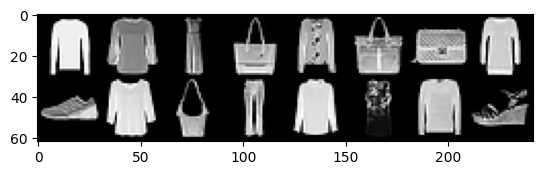

Labels:  2 6 3 8 6 8 8 0 7 6 8 1 6 0 2 5


In [95]:
# display sample input images
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

num_samples = 16
imshow(torchvision.utils.make_grid(imgs[:num_samples]))
print('Labels: ', ' '.join(f'{lbls[j]}' for j in range(num_samples)))

In [96]:
# Normalization check
print(imgs.max())
print(imgs.min())

tensor(1.)
tensor(0.)


In [97]:
# input -> hidden -> mu, sigma -> reparameterization trick -> hidden -> output
class VAE(nn.Module):
    def __init__(self, input_dim=784, h_dim=512, z_dim=2):
        super(VAE, self).__init__()

        # Encoder
        self.in_hid = nn.Linear(input_dim, h_dim)  # Encoder: Input 784 (28x28), hidden layer 512
        self.hid_mu = nn.Linear(h_dim, z_dim)   # Mean of latent space
        self.hid_logvar = nn.Linear(h_dim, z_dim)   # Log variance of latent space

        # Decoder
        self.z_hid = nn.Linear(z_dim, h_dim)    # Decoder: Latent space 2, hidden layer 512
        self.hid_out = nn.Linear(h_dim, input_dim)  # Decoder: Output 784 (28x28)

        self.relu = nn.ReLU()     # hidden layer activation function - ReLU
        self.sigmoid = nn.Sigmoid()     # Sigmoid to output values between 0 and 1

    def encode(self, x):
        h = self.relu(self.in_hid(x))
        mu, logvar = self.hid_mu(h), self.hid_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        sigma = torch.exp(0.5*logvar)
        epsilon = torch.randn_like(sigma)
        z = mu + epsilon * sigma
        return z

    def decode(self, z):
        h = self.relu(self.z_hid(z))
        final_layer = self.sigmoid(self.hid_out(h))
        return final_layer

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        x_hat = self.decode(z)
        return x_hat, mu, logvar

# Loss function
def loss_function(x_hat, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(x_hat, x.view(-1, 784), reduction='sum') # Reconstruction loss
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) # KL divergence
    return BCE + KLD

In [98]:
# configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [99]:
print(model)

VAE(
  (in_hid): Linear(in_features=784, out_features=512, bias=True)
  (hid_mu): Linear(in_features=512, out_features=2, bias=True)
  (hid_logvar): Linear(in_features=512, out_features=2, bias=True)
  (z_hid): Linear(in_features=2, out_features=512, bias=True)
  (hid_out): Linear(in_features=512, out_features=784, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)


In [100]:
# x = torch.randn(4, 28*28)
x_hat, mu, sigma = model(imgs)
print(x_hat.shape)
print(mu.shape)
print(sigma.shape)

torch.Size([128, 784])
torch.Size([128, 2])
torch.Size([128, 2])


**3. When executed the notebook should output the following:
a. Training curves (loss vs epochs) (25 pts)**

100%|██████████| 469/469 [00:18<00:00, 25.00it/s]


Epoch 1, Loss: 291.5407866861979


100%|██████████| 469/469 [00:19<00:00, 24.50it/s]


Epoch 2, Loss: 272.037960546875


100%|██████████| 469/469 [00:20<00:00, 22.76it/s]


Epoch 3, Loss: 269.01458658854165


100%|██████████| 469/469 [00:20<00:00, 23.31it/s]


Epoch 4, Loss: 267.47187044270834


100%|██████████| 469/469 [00:20<00:00, 23.31it/s]


Epoch 5, Loss: 266.3558345377604


100%|██████████| 469/469 [00:20<00:00, 22.61it/s]


Epoch 6, Loss: 265.4395188151042


100%|██████████| 469/469 [00:19<00:00, 23.77it/s]


Epoch 7, Loss: 264.86192646484375


100%|██████████| 469/469 [00:20<00:00, 22.64it/s]


Epoch 8, Loss: 264.1255269205729


100%|██████████| 469/469 [00:19<00:00, 23.56it/s]


Epoch 9, Loss: 263.5539311197917


100%|██████████| 469/469 [00:20<00:00, 22.46it/s]


Epoch 10, Loss: 263.1152521484375


100%|██████████| 469/469 [00:20<00:00, 23.12it/s]


Epoch 11, Loss: 262.657147265625


100%|██████████| 469/469 [00:20<00:00, 22.63it/s]


Epoch 12, Loss: 262.36419850260415


100%|██████████| 469/469 [00:21<00:00, 22.13it/s]


Epoch 13, Loss: 261.97702724609377


100%|██████████| 469/469 [00:20<00:00, 23.44it/s]


Epoch 14, Loss: 261.64908333333335


100%|██████████| 469/469 [00:21<00:00, 22.26it/s]


Epoch 15, Loss: 261.3739030273438


100%|██████████| 469/469 [00:20<00:00, 22.64it/s]


Epoch 16, Loss: 261.0877736653646


100%|██████████| 469/469 [00:21<00:00, 22.24it/s]


Epoch 17, Loss: 260.8860129231771


100%|██████████| 469/469 [00:21<00:00, 21.92it/s]


Epoch 18, Loss: 260.65123837890627


100%|██████████| 469/469 [00:20<00:00, 22.78it/s]


Epoch 19, Loss: 260.4524073893229


100%|██████████| 469/469 [00:21<00:00, 21.80it/s]


Epoch 20, Loss: 260.1713201497396


100%|██████████| 469/469 [00:21<00:00, 21.62it/s]


Epoch 21, Loss: 260.0913521809896


100%|██████████| 469/469 [00:20<00:00, 22.57it/s]


Epoch 22, Loss: 259.9177982747396


100%|██████████| 469/469 [00:21<00:00, 21.41it/s]


Epoch 23, Loss: 259.72155709635416


100%|██████████| 469/469 [00:21<00:00, 21.51it/s]


Epoch 24, Loss: 259.6351443684896


100%|██████████| 469/469 [00:20<00:00, 22.36it/s]


Epoch 25, Loss: 259.4996565104167


100%|██████████| 469/469 [00:22<00:00, 21.30it/s]


Epoch 26, Loss: 259.4089411783854


100%|██████████| 469/469 [00:22<00:00, 21.25it/s]


Epoch 27, Loss: 259.3132902669271


100%|██████████| 469/469 [00:21<00:00, 22.15it/s]


Epoch 28, Loss: 259.21134147135416


100%|██████████| 469/469 [00:22<00:00, 21.16it/s]


Epoch 29, Loss: 258.9667632161458


100%|██████████| 469/469 [00:22<00:00, 20.99it/s]


Epoch 30, Loss: 258.9940404296875


100%|██████████| 469/469 [00:21<00:00, 21.74it/s]


Epoch 31, Loss: 258.8471089518229


100%|██████████| 469/469 [00:22<00:00, 20.90it/s]


Epoch 32, Loss: 258.7439593424479


100%|██████████| 469/469 [00:22<00:00, 20.79it/s]


Epoch 33, Loss: 258.7215552083333


100%|██████████| 469/469 [00:22<00:00, 20.75it/s]


Epoch 34, Loss: 258.64583082682293


100%|██████████| 469/469 [00:21<00:00, 21.65it/s]


Epoch 35, Loss: 258.47959114583335


100%|██████████| 469/469 [00:22<00:00, 20.62it/s]


Epoch 36, Loss: 258.49031689453125


100%|██████████| 469/469 [00:23<00:00, 20.33it/s]


Epoch 37, Loss: 258.37671708984374


100%|██████████| 469/469 [00:23<00:00, 20.35it/s]


Epoch 38, Loss: 258.26782526041666


100%|██████████| 469/469 [00:22<00:00, 21.09it/s]


Epoch 39, Loss: 258.2117895833333


100%|██████████| 469/469 [00:23<00:00, 20.18it/s]


Epoch 40, Loss: 258.15575045572916


100%|██████████| 469/469 [00:23<00:00, 20.14it/s]


Epoch 41, Loss: 258.1234369140625


100%|██████████| 469/469 [00:23<00:00, 20.01it/s]


Epoch 42, Loss: 258.00423525390624


100%|██████████| 469/469 [00:23<00:00, 19.97it/s]


Epoch 43, Loss: 258.03865283203123


100%|██████████| 469/469 [00:22<00:00, 20.61it/s]


Epoch 44, Loss: 257.8602998046875


100%|██████████| 469/469 [00:23<00:00, 19.74it/s]


Epoch 45, Loss: 257.83986845703123


100%|██████████| 469/469 [00:23<00:00, 19.77it/s]


Epoch 46, Loss: 257.79468470052086


100%|██████████| 469/469 [00:23<00:00, 19.67it/s]


Epoch 47, Loss: 257.77258209635414


100%|██████████| 469/469 [00:23<00:00, 19.63it/s]


Epoch 48, Loss: 257.6917006510417


100%|██████████| 469/469 [00:23<00:00, 19.92it/s]


Epoch 49, Loss: 257.57120035807293


100%|██████████| 469/469 [00:23<00:00, 19.86it/s]


Epoch 50, Loss: 257.59215


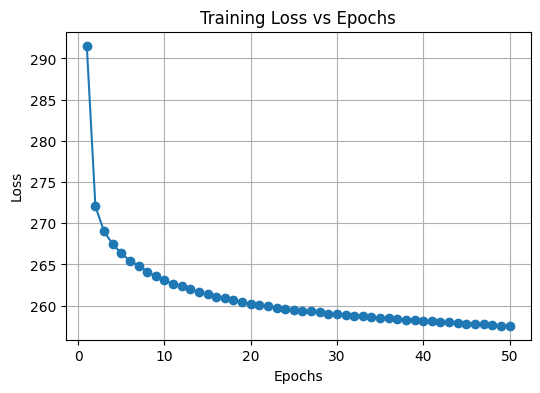

In [101]:
# Training

epochs = 50
train_losses = []

for epoch in range(epochs):
    model.train()
    train_loss = 0
    loop = tqdm(enumerate(train_loader), total=len(train_loader))
    for batch_idx, (x, _) in loop:
        x = x.to(device)

        # Forward Pass
        x_hat, mu, logvar = model(x)

        # Compute loss
        loss = loss_function(x_hat, x, mu, logvar)

        # BackPropagation
        optimizer.zero_grad()
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    avg_loss = train_loss / len(train_loader.dataset)
    train_losses.append(avg_loss)
    print(f'Epoch {epoch + 1}, Loss: {avg_loss}')

# Plot training loss curves
plt.figure(figsize=(6, 4))
plt.plot(range(1, epochs + 1), train_losses, marker='o')
plt.title('Training Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

**b. 2D-scatter plot of the 𝑧 values corresponding to a random subset of 5000
FashionMNIST input images (outputs of the encoder followed by reparameterization) (example below) (25 pts)**

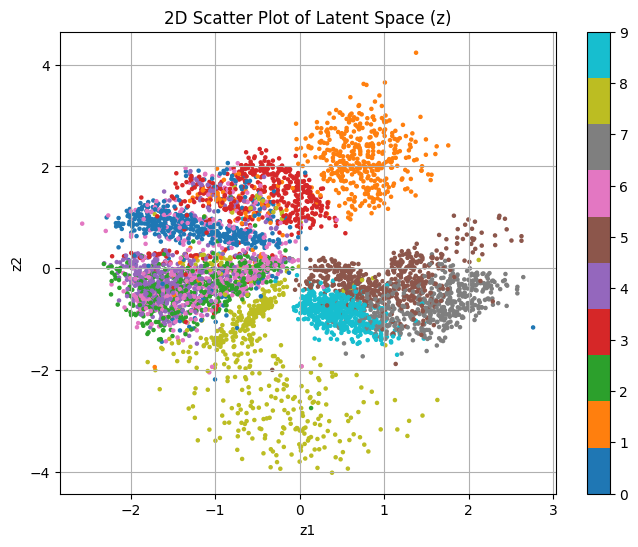

In [102]:
import numpy as np

# Select a random subset of 5000 FashionMNIST images
subset_size = 5000
indices = np.random.choice(len(train_loader.dataset), subset_size, replace=False)

z_values = []
labels = []

# Evaluation mode
model.eval()

with torch.no_grad():
    for idx in indices:
        # Fetch image and pass it through the encoder
        image, label = train_loader.dataset[idx]
        image = image.unsqueeze(0).to(device)  # Add batch dimension and send to device

        # Forward pass through encoder to get mu and logvar
        mu, logvar = model.encode(image.view(-1, 784))

        # Reparameterize to get latent variable z
        z = model.reparameterize(mu, logvar)

        # Store the z value and corresponding label
        z_values.append(z.cpu().numpy())
        labels.append(label)

# Convert to numpy arrays for plotting
z_values = np.array(z_values).reshape(-1, 2)  # Shape into (5000, 2) for 2D scatter plot
labels = np.array(labels)

# Plot 2D scatter plot of the z values
plt.figure(figsize=(8, 6))
plt.scatter(z_values[:, 0], z_values[:, 1], c=labels, cmap='tab10', s=5)
plt.colorbar()
plt.title('2D Scatter Plot of Latent Space (z)')
plt.xlabel('z1')
plt.ylabel('z2')
plt.grid(True)
plt.show()


**c. A grid plot of 15x15 generated images which are the outputs of the decoder generated for the complete range of 𝑧 values across the two components of 𝑧. (example below) (25 pts)**

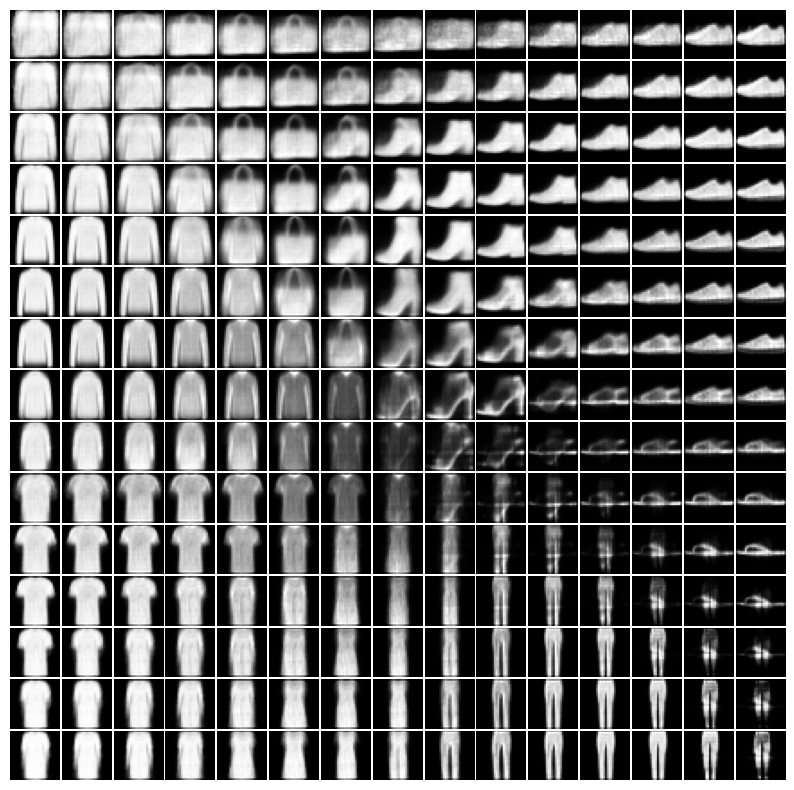

In [103]:
# Define the number of grid points and the range of z values
grid_size = 15
z_range = 2  # This range should correspond to the variation in your latent space z

# Create a 2D grid of z values
z_values = np.linspace(-z_range, z_range, grid_size)
z_grid = np.array([[torch.tensor([z1, z2]).float() for z1 in z_values] for z2 in z_values])

# Initialize figure for plotting
fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))
plt.subplots_adjust(hspace=0.05, wspace=0.05)


# Loop through each point in the grid and generate images
with torch.no_grad():
    for i, z_row in enumerate(z_grid):
        for j, z in enumerate(z_row):
            z = torch.tensor(z).unsqueeze(0).float().to(device)  # Convert z to a PyTorch tensor and add batch dimension

            # Pass z through the decoder to generate the image
            generated_image = model.decode(z).cpu().view(28, 28).numpy()  # Assuming the decoder outputs 28x28 images

            # Plot the generated image
            axes[i, j].imshow(generated_image, cmap='gray')
            axes[i, j].axis('off')  # Turn off axis labels for a cleaner look

# Show the grid of generated images
plt.show()

**d. Create a grid of generated images where each row/column corresponds to varying images for one category. Identify the 𝑧 values that will generate the category and vary the 𝑧 to generate 5 samples for each category. (Sample image below) (25 pts)**

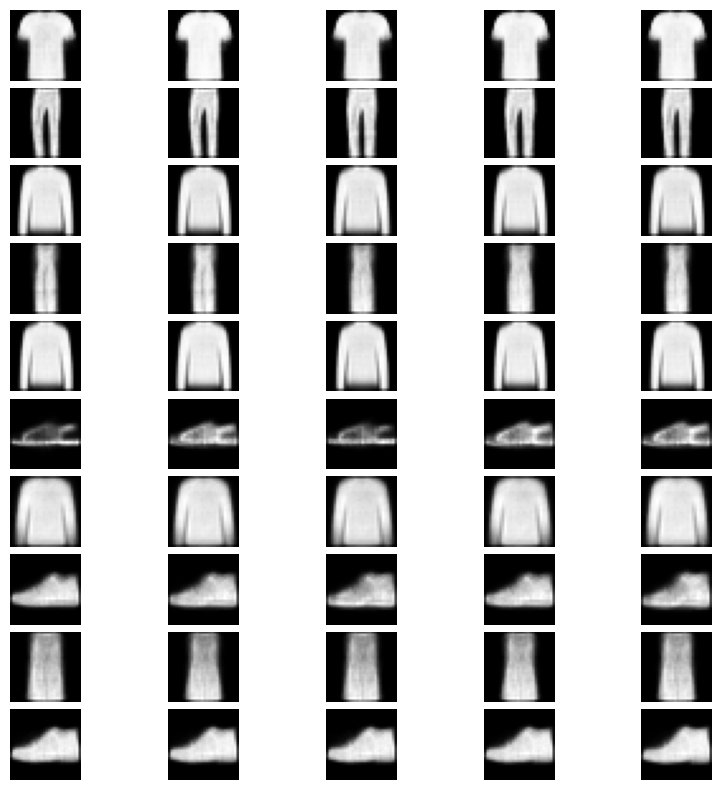

In [104]:
# Number of categories in FashionMNIST (10) and number of variations (5 per category)
num_categories = 10
num_samples_per_category = 5


# Store the latent vectors for each category
latent_vectors_by_category = {i: [] for i in range(num_categories)}

with torch.no_grad():
    for data, target in train_loader:
        data = data.to(device)
        # Flatten the input data
        data = data.view(data.size(0), -1) #  Reshape the data to have 784 features per sample
        mu, logvar = model.encode(data)  # Get the latent mean (mu) and log variance (logvar)
        z = model.reparameterize(mu, logvar)  # Reparameterize to get latent vector

        for i in range(data.size(0)):
            label = target[i].item()  # Get the label of the image
            latent_vectors_by_category[label].append(z[i].cpu().numpy())  # Store the latent vector for that label

# Select 5 random latent vectors from each category and generate slight variations
grid_images = []

for category in range(num_categories):
    # Randomly select one latent vector for this category
    base_z = np.array(latent_vectors_by_category[category][0])

    # Create variations of this latent vector by adding small noise
    variations = [base_z + np.random.normal(scale=0.1, size=base_z.shape) for _ in range(num_samples_per_category)]

    # Decode each variation to generate an image
    row_images = []
    for variation in variations:
        z_tensor = torch.tensor(variation).unsqueeze(0).float().to(device)  # Convert to tensor and add batch dimension
        generated_image = model.decode(z_tensor).cpu().detach().view(28, 28).numpy()  # Decode the latent vector and detach before converting to numpy

        row_images.append(generated_image)  # Store the generated image

    grid_images.append(row_images)  # Store the row of images for this category

# Plot the grid of generated images
fig, axes = plt.subplots(num_categories, num_samples_per_category, figsize=(10, 10))
plt.subplots_adjust(hspace=0.1, wspace=0.1)

for i, row_images in enumerate(grid_images):
    for j, img in enumerate(row_images):
        axes[i, j].imshow(img, cmap='gray')
        axes[i, j].axis('off')  # Turn off axis labels for a cleaner look

plt.show()